# Import

In [1]:
# Data structure libaries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KernelDensity

# Math libraries
from statistics import mean 

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [4]:
df = pd.read_csv('processed_data_II33.csv')

# Train - Validation - Test Split

In [11]:
# All feature data
features = df.iloc[:,:-1]
# All label data
labels = df.iloc[:,-1:].values.ravel()

# Using the remaining training records, split into validation, slightly larger split to make it comparable to test size
og_feature_train, feature_val, og_label_train, label_val = train_test_split(features, labels, test_size=0.15, stratify=labels)

# Kernel Density Estimation (Rank Removal)

In [12]:
def rank_removal(x_train, y_train, feature_col, y_col, rank_threshold) :
    '''
        :param x_train: the np array of learning data
        :param y_train: the np array of labels for learning data
        :param feature_col: actual column names []
        :param y_col: the label column
        :param rank_threshold: the percentage of data we want to drop (like 0.30 to keep the top 70% of the data)
        :returns x_train_df, y_train_df, x_train, y_train, rows_to_drop: returns the dataframe versions of the remaining rows after removal, as well as the indicies of the rows dropped
    '''
    # Convert to 2d tabular data
    x_train_df = pd.DataFrame(x_train, columns = feature_col)
    y_train_df = pd.DataFrame(y_train, columns = [y_col])
    
    # Fit the data for the kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_train_df)
    # Caculate the probability density 
    logprob = kde.score_samples(x_train_df)

    # Drop the bottom k%, keeping the top k%
    perc = rank_threshold
    perc = int(len(logprob) * perc)

    print('Drop Bottom ' + str(rank_threshold * 100) + '%')
    rows_to_drop = np.argpartition(logprob, perc)[:perc]
    print('Number of rows dropped: ', str(len(rows_to_drop)))
    
    x_train_df = x_train_df.drop(rows_to_drop, axis=0)
    y_train_df = y_train_df.drop(rows_to_drop, axis=0)
    
    return x_train_df, y_train_df, rows_to_drop

In [13]:
feature_col = ['RIDAGEYR', 'DPQ020', 'DPQ040', 'BMXBMI', 'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT',
               'DR1IPFAT', 'DR1IMFAT', 'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT',
               'DR2IMFAT', 'SLD012', 'SLQ120']
y_col = ['sleep_disorder']

In [14]:
# Specify the bottom % to drop
rank_threshold = 0.50
feature_train, label_train, rows_dropped = rank_removal(np.array(og_feature_train), np.array(og_label_train), feature_col, y_col, rank_threshold)

Drop Bottom 50.0%
Number of rows dropped:  482


In [15]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf'],
              'gamma': [0.01, 0.1, 1, 10]}

# Create the SVM model
svm_model0 = SVC()

# Perform Grid Search
grid_search = GridSearchCV(svm_model0, param_grid, cv=3, scoring='accuracy')
grid_search.fit(feature_train, label_train)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Initialize lists to store performance metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
params_list = grid_search.cv_results_


# Perform cross-validation to get performance metrics for each parameter combination
for params in grid_search.cv_results_['params']:
    svm_model0 = SVC(**params)
    svm_model0.fit(og_feature_train, og_label_train)
    # svm_model0.fit(feature_train, label_train)
    
    # Predictions on validation set
    y_pred_val = svm_model0.predict(feature_val)
    
    # Calculate performance metrics
    accuracy = accuracy_score(label_val, y_pred_val)
    precision = precision_score(label_val, y_pred_val, average='weighted')
    recall = recall_score(label_val, y_pred_val, average='weighted')
    f1 = f1_score(label_val, y_pred_val, average='weighted')
    
    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Print the best parameters
print("Best Parameters:", best_params)

# Print performance metrics for each parameter combination
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"\nParameters: {params}")
    print(f"Accuracy: {accuracy_list[i]}")
    print(f"Precision: {precision_list[i]}")
    print(f"Recall: {recall_list[i]}")
    print(f"F1 Score: {f1_list[i]}")

/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_cl

Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Accuracy: 0.7076023391812866
Precision: 0.5007010704148285
Recall: 0.7076023391812866
F1 Score: 0.5864375550749018

Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.7076023391812866
Precision: 0.5007010704148285
Recall: 0.7076023391812866
F1 Score: 0.5864375550749018

Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy: 0.7076023391812866
Precision: 0.5007010704148285
Recall: 0.7076023391812866
F1 Score: 0.5864375550749018

Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.7076023391812866
Precision: 0.5007010704148285
Recall: 0.7076023391812866
F1 Score: 0.5864375550749018

Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.7076023391812866
Precision: 0.5007010704148285
Recall: 0.7076023391812866
F1 Score: 0.5864375550749018

Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.7076023391812866


/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
index_list = [num for num in range(len(accuracy_list))]
print(index_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


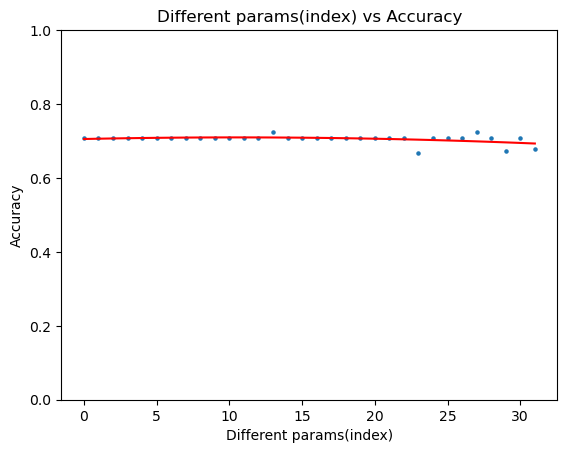

In [18]:
plt.scatter(index_list, accuracy_list, s=5)
plt.title('Different params(index) vs Accuracy')
plt.xlabel('Different params(index)')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# Calculate equation for trendline
z = np.polyfit(index_list, accuracy_list, 2)
p = np.poly1d(z)

plt.plot(index_list, p(index_list), color='red')

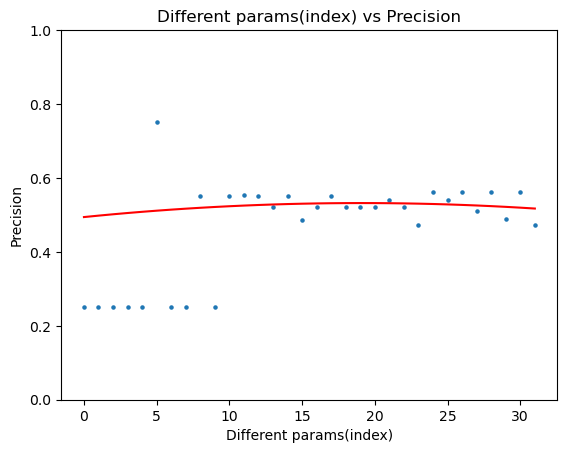

In [88]:
plt.scatter(index_list, precision_list, s=5)
plt.title('Different params(index) vs Precision')
plt.xlabel('Different params(index)')
plt.ylabel('Precision')
plt.ylim(0, 1.0)

# Calculate equation for trendline
z = np.polyfit(index_list, accuracy_list, 2)
p = np.poly1d(z)

plt.plot(index_list, p(index_list), color='red')

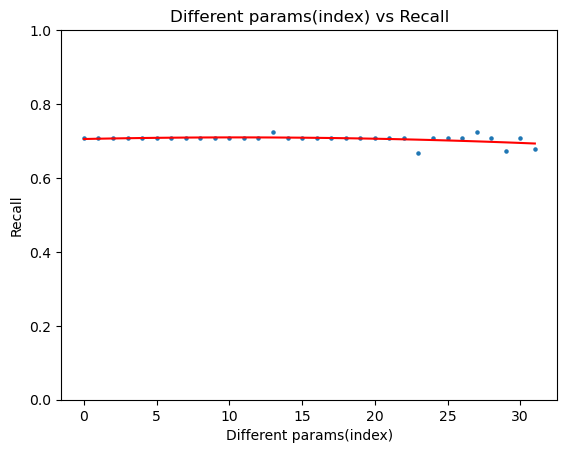

In [19]:
plt.scatter(index_list, recall_list, s=5)
plt.title('Different params(index) vs Recall')
plt.xlabel('Different params(index)')
plt.ylabel('Recall')
plt.ylim(0, 1.0)

# Calculate equation for trendline
z = np.polyfit(index_list, recall_list, 2)
p = np.poly1d(z)

plt.plot(index_list, p(index_list), color='red')

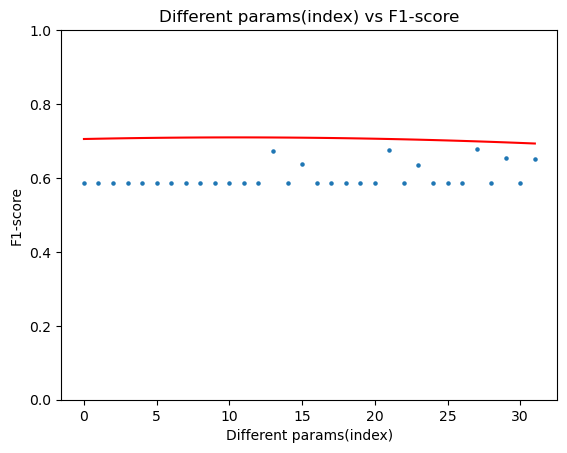

In [20]:
plt.scatter(index_list, f1_list, s=5)
plt.title('Different params(index) vs F1-score')
plt.xlabel('Different params(index)')
plt.ylabel('F1-score')
plt.ylim(0, 1.0)

# Calculate equation for trendline
z = np.polyfit(index_list, recall_list, 2)
p = np.poly1d(z)

plt.plot(index_list, p(index_list), color='red')

In [ ]:
# Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}

In [24]:
svm_params = {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}

svm_model1 = SVC(**svm_params)

svm_model.fit(feature_train, label_train)

label_pred = svm_model.predict(feature_val)

accuracy = accuracy_score(label_val, label_pred)
conf_matrix = confusion_matrix(label_val, label_pred)
classification_rep = classification_report(label_val, label_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

# og_feature_train, feature_val, og_label_train, label_val = train_test_split(features, labels, test_size=0.15, stratify=labels)

Accuracy: 0.7251461988304093
Confusion Matrix:
[[  5  45]
 [  2 119]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.10      0.18        50
         1.0       0.73      0.98      0.84       121

    accuracy                           0.73       171
   macro avg       0.72      0.54      0.51       171
weighted avg       0.72      0.73      0.64       171



/Users/a200/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Decision Surface